In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv('train.csv')

In [5]:

print(data.columns)
categorical_cols = data.select_dtypes(include=['object']).columns
final = data.drop(categorical_cols, axis=1)
y = final['price']
X = final.drop(columns=['price'])
print(X.shape)

scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X)

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'Black or NOT'],
      dtype='object')
(188533, 4)
[[-1.73204162 -1.55980788  2.95784224 -0.59326362]
 [-1.73202325 -2.4430515   1.55718431 -0.59326362]
 [-1.73200487 -2.4430515   1.42627551 -0.59326362]
 ...
 [ 1.73200487  0.91327427 -1.04532849         nan]
 [ 1.73202325  1.089923   -1.04040861         nan]
 [ 1.73204162  0.03003065 -0.12460926         nan]]


In [7]:
# Convert to PyTorch tensors
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
X_train = torch.nan_to_num(X_train, nan=0.0)  # Replace NaN with 0
y_train = torch.nan_to_num(y_train, nan=0.0)
dataset = TensorDataset(X_train, y_train)
# Create separate DataLoaders first
from torch.utils.data import DataLoader, random_split

# Assuming you have a full_dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=10)
test_dataloader = DataLoader(test_dataset, batch_size=10)



# Define the model
model = nn.Sequential(
    nn.Linear(37, 23),
    nn.LeakyReLU(),
    nn.Linear(23, 9),
    nn.LeakyReLU(),
    nn.Linear(9, 3),
    nn.LeakyReLU(),
    nn.Linear(3, 1)
)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
training_losses = []  # Store training loss for each epoch
validation_losses = []  # Store validation loss for each epoch
# Training loop
epochs = 30
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_dataloader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    training_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_dataloader:
            val_predictions = model(batch_X)
            vloss = criterion(val_predictions, batch_y)
            val_loss += vloss.item()
    val_loss /= len(val_dataloader)
    validation_losses.append(val_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    




RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x4 and 37x23)

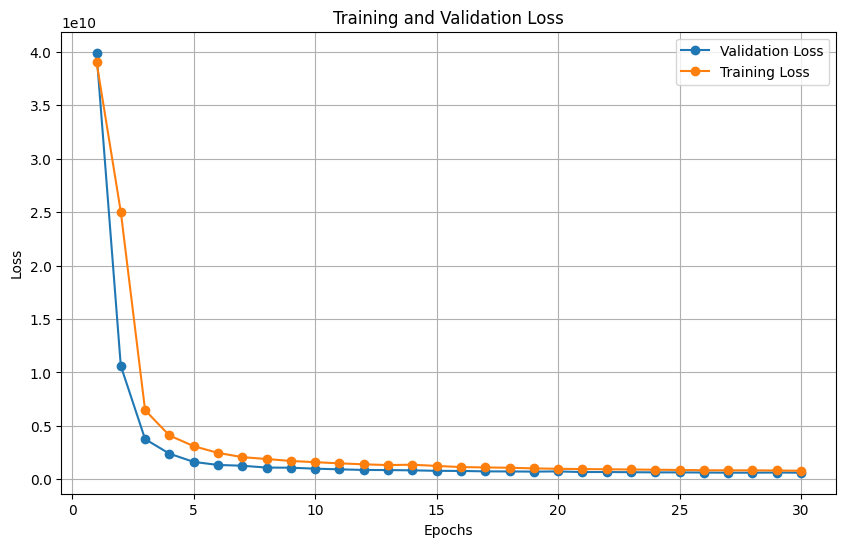

In [10]:
# Plotting the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss', marker='o')
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Testing
model.eval()
test_loss = 0.0
all_preds = []
all_targets = []
with torch.no_grad():
    for batch_X, batch_y in test_dataloader:
        predictions = model(batch_X)
        test_loss += criterion(predictions, batch_y).item()
        all_preds.extend(predictions.numpy())
        all_targets.extend(batch_y.numpy())
test_loss /= len(test_dataloader)

print(f"\nFinal Test Loss: {test_loss:.4f}")

# Additional metric (MAE)
mae = nn.L1Loss()
test_mae = mae(torch.tensor(all_preds), torch.tensor(all_targets))
print(f"Test MAE: {test_mae:.4f}")


Final Test Loss: 1619207134.5455
Test MAE: 19642.8730


C:\Users\jalle\AppData\Local\Temp\ipykernel_18476\1197664052.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  test_mae = mae(torch.tensor(all_preds), torch.tensor(all_targets))


In [14]:
# Testing with a sample input
test = pd.read_csv('test.csv')
categorical_cols = test.select_dtypes(include=['object']).columns
test = test.drop(categorical_cols, axis=1)
scaler = StandardScaler()
test = scaler.fit_transform(test)

sample_input = torch.tensor(test, dtype=torch.float32)
#sample_input = torch.nan_to_num(sample_input, nan=0.0)
model.eval()
predicted_value = model(sample_input)
predicted_value

tensor([[125566.0781],
        [152377.0469],
        [183296.7031],
        ...,
        [194947.0469],
        [        nan],
        [273841.5938]], grad_fn=<AddmmBackward0>)

In [16]:
predictions = pd.DataFrame(predicted_value.detach().numpy())
a = pd.read_csv('sample_submission.csv')
file = pd.concat([a['Id'],predictions],axis=1)
file.columns = ['Id','SalePrice']
file.to_csv('neuralnetworksubmisssion.csv',index=False)